https://qiita.com/triwave33/items/f6352a40bcfbfdea0476  
  
通常のGANだとただひたすら訓練データの分布に$z$が近づけられる．  
数字の書き分けのようなカテゴリ情報は，訓練時に$z$から切り離して与えてやる．  
これがConditional GAN  

要は  
discriminatorに「今は、6について本物か偽物かを判定してるんですよー」とか  
generatorに「今は、3を書くという条件のもとに画像を生成してるんですよー」ということを  
教えてやるわけです。  
  
generatorとdiscriminatorの各入力にラベル情報$y$を混ぜてあげるだけ  
下図は下から進むGAN
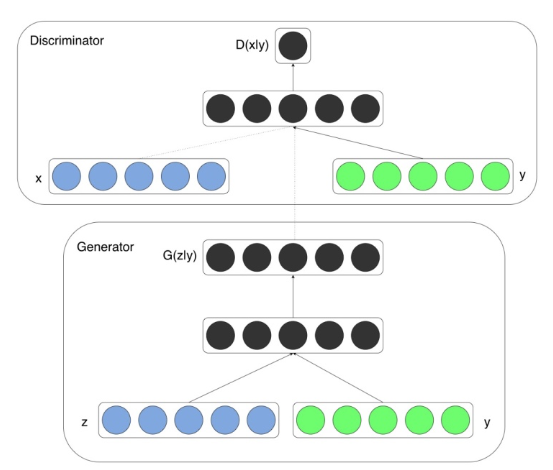

## Conditional GANのGenerator
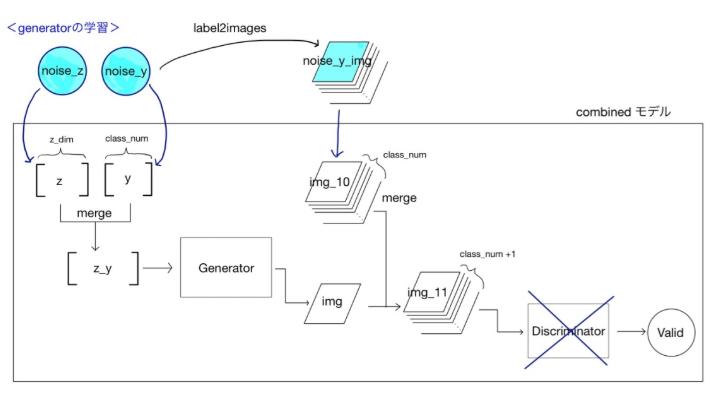

ラベルは0～9のone-hotベクトルを用いる  
$z$と$y$の結合方法は主に2つ  
1. $z$と$y$は別々に流し込んでgenerator内で結合
2. $z$と$y$と結合してgeneratorに渡す

generatorとdiscriminator単体は2だが，combinedモデルは1になっている   
変数の数をなるべく増やさないため  
構造設計の基本思想としては，データフォーマットを基本構造から変えたくない    

### Generator学習時のdiscriminatorへの数値ラベルの入力
(batch_num, 28, 28, 1)の画像データに対し，チャンネル数を10増やし，(batch_num, 28, 28, 11)にする  
その10チャンネルは，例えば画像が3なら4番目のチャンネルの画像がすべて1，そのほかの画像はすべて0  
かなり強引感はある  
[DRAGAN](http://yusuke-ujitoko.hatenablog.com/entry/2017/10/24/203133)という手法では，discriminatorの中間層(少ない要素数で渡せる)にラベル情報を入れていて，なお安定している模様  
しかしDRAGANはdiscriminatorの入力値の平均を取るGAN-gpでは使えない？  
他にも，ラベルの入れ方は色々ありそう

### Combinedモデルの作成
上図のとおり，z, y, img10をとり，内部で利用

## Discriminator学習時
実データをあらかじめ結合してからdiscriminatorに渡す  
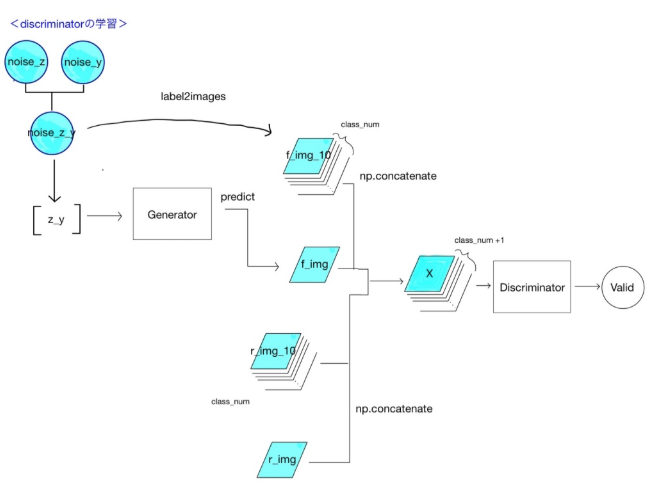

In [1]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Reshape, concatenate, Input
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Convolution2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Flatten, Dropout
from keras.optimizers import Adam
from keras.datasets import mnist
import math
import numpy as np

CLASS_NUM = 10

class CGAN():
    def __init__(self, z_dim=100, img_dir="images/cgan/"):
        self.path = img_dir
        
        #mnistデータ用の入力データサイズ
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # 潜在変数の次元数
        self.z_dim = z_dim

        # discriminatorモデル
        self.discriminator = self.build_discriminator()
        self.discriminator_optimizer = Adam(lr=1e-5, beta_1=0.1)
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=self.discriminator_optimizer,
            metrics=['accuracy'])

        # Generatorモデル
        self.generator = self.build_generator()
        
        # Combined
        self.combined = self.build_combined()
        self.discriminator.trainable=False
        self.combined_optimizer = Adam(lr=.8e-4, beta_1=0.5)
        self.combined.compile(
            loss='binary_crossentropy', 
            optimizer=self.combined_optimizer,\
            metrics=['accuracy']
        )

    
    def build_generator(self):
        model = Sequential()
        # DCGANとの相違点は入力の次元がCLASS分だけ追加されているだけ
        model.add(Dense(input_dim=(self.z_dim + CLASS_NUM), output_dim=1024)) # z=100, y=10
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dense(128*7*7))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Reshape((7,7,128), input_shape=(128*7*7,)))
        model.add(UpSampling2D((2,2)))
        model.add(Convolution2D(64,5,5,border_mode='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(UpSampling2D((2,2)))
        model.add(Convolution2D(1,5,5,border_mode='same'))
        model.add(Activation('tanh'))
        return model
    
    
    def build_discriminator(self):
        model = Sequential()
        # DCGANとの相違点は入力のチャンネル数がCLASS分だけ追加されていること
        model.add(Convolution2D(64,5,5,\
              subsample=(2,2),\
              border_mode='same',\
              input_shape=(self.img_rows,self.img_cols,(1+CLASS_NUM))))
        model.add(LeakyReLU(0.2))
        model.add(Convolution2D(128,5,5,subsample=(2,2)))
        model.add(LeakyReLU(0.2))
        model.add(Flatten())
        model.add(Dense(256))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.5))
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        return model
    
    
    def build_combined(self):
        z = Input(shape=(self.z_dim,))
        y = Input(shape=(CLASS_NUM,))
        img_10 = Input(shape=(self.img_rows, self.img_cols, CLASS_NUM,))
        z_y = concatenate([z, y])
        
        img = self.generator(z_y) # [batch, W, H, C=1]
        img_11 = concatenate([img, img_10], axis=3)
        self.discriminator.trainable = False
        valid = self.discriminator(img_11)
        model = Model(input=[z, y, img_10], output=valid)
        return model
    
    
    def combine_images(self,generated_images):
        total = generated_images.shape[0]
        cols = int(math.sqrt(total))
        rows = int(math.ceil(float(total)/cols))
        WIDTH, HEIGHT = generated_images.shape[1:3]
        combined_image = np.zeros((HEIGHT*rows, WIDTH*cols),
                    dtype=generated_images.dtype)

        for index, image in enumerate(generated_images):
            i = int(index/cols)
            j = index % cols
            combined_image[WIDTH*i:WIDTH*(i+1), HEIGHT*j:HEIGHT*(j+1)] = image[:, :,0]
        return combined_image

    def label2images(self,label):
        # ラベルの全面だけ1にした10チャンネルの画像を返す
        images = np.zeros((self.img_rows,self.img_cols,CLASS_NUM))
        images[:,:,label] += 1
        return images

    def label2onehot(self,label):
        # ラベルからone-hotベクトルを返す
        onehot = np.zeros(CLASS_NUM)
        onehot[label] = 1
        return onehot
    
    def train(self, epochs=5000, batch_size=128, save_interval=1000):
        (X_train, y_train), (_, _) = mnist.load_data()
        X_train = (X_train.astype(np.float32) - 127.5)/127.5
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2],1)

        # 学習結果を格納
        self.g_loss_array = np.zeros(epochs)
        self.d_loss_array = np.zeros(epochs)
        self.d_accuracy_array = np.zeros(epochs)
        self.d_predict_true_num_array = np.zeros(epochs)

        num_batches = int(X_train.shape[0] / batch_size)

        for epoch in range(epochs):
            for index in range(num_batches):
                # generator用データ整形
                noise_z = np.array([np.random.uniform(-1, 1, self.z_dim) for _ in range(batch_size)])
                noise_y_int = np.random.randint(0, CLASS_NUM, batch_size) # label番号を生成する乱数
                noise_y = np.array([self.label2onehot(i) for i in noise_y_int]) # (batch, class)
                noise_z_y = np.concatenate((noise_z, noise_y),axis=1) # zとyを結合
                f_img = self.generator.predict(noise_z_y, verbose=0)
                f_img_10 = np.array([self.label2images(i) for i in noise_y_int]) # 生成データラベルの10ch画像
                f_img_11 = np.concatenate((f_img, f_img_10),axis=3)

                # discriminator用データ整形
                r_img = X_train[index*batch_size:(index+1) * batch_size] # 実データの画像
                label_batch = y_train[index*batch_size:(index+1) * batch_size] # 実データのラベル
                r_img_10 = np.array([self.label2images(i) for i in label_batch]) # 実データラベルの10ch画像
                r_img_11 = np.concatenate((r_img, r_img_10), axis=3)

                # discriminatorを更新
                X = np.concatenate((r_img_11, f_img_11))
                y = [1]*batch_size + [0]*batch_size
                y = np.array(y)
                d_loss = self.discriminator.train_on_batch(X, y)

                # generatorを更新
                noise = np.array([np.random.uniform(-1, 1, self.z_dim) for _ in range(batch_size)])
                randomLabel_batch = np.random.randint(0, CLASS_NUM, batch_size) # label番号を生成する乱数
                randomLabel_batch_onehot = np.array([self.label2onehot(i) for i in randomLabel_batch]) # (batch. class)
                randomLabel_batch_image = np.array([self.label2images(i) for i in randomLabel_batch]) # 生成データラベルの10ch画像
                g_loss = self.combined.train_on_batch([noise, randomLabel_batch_onehot, randomLabel_batch_image], np.array([1]*batch_size))

            # np.ndarrayにloss関数を格納
            self.g_loss_array[epoch] = g_loss
            self.d_loss_array[epoch] = d_loss[0]
            self.d_accuracy_array[epoch] = 100. * d_loss[1]
                
            # 生成画像を出力
            if epoch % save_interval == 0:
                print("epoch: %d, batch: %d, g_loss: %f, d_loss: %f" % (epoch, index, g_loss, d_loss[0]))
                noise = np.array([np.random.uniform(-1, 1, self.z_dim) for _ in range(IMG_TOTAL_NUM)])
                randomLabel_batch = np.arange(100) % 10  # label番号を生成する乱数,BATCH_SIZE長
                randomLabel_batch_onehot = np.array([self.label2onehot(i) for i in randomLabel_batch]) #shape[0]:batch, shape[1]:class
                noise_with_randomLabel = np.concatenate((noise, randomLabel_batch_onehot),axis=1) # zとyを結合
                generated_images = self.generator.predict(noise_with_randomLabel, verbose=0)
                image = self.combine_images(generated_images)
                image = image * 127.5 + 127.5
                if not os.path.exists(self.path):
                    os.mkdir(self.path)
                Image.fromarray(image.astype(np.uint8))\
                    .save(self.path+"%04d_%04d.png" % (epoch, index))

Using TensorFlow backend.


In [ ]:
gan = CGAN()
gan.train(epochs=5001, save_interval=1000)

[7章](https://qiita.com/triwave33/items/d94e5291d45e1d2bdd40)は結果のみなので省略  
z_dimは50～100がちょうどいい  
one-hotラベルを指定して与えることで目的の画像を生成してくれる  
two-hotラベルにしてみると，例えば3,7なら，3と7が混ざったような画像が出てくる  